# Predicting Stock Prices with a Long-Short Term Memory (LSTM) Predictive Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
import pandas as pd

import yfinance as yf # Data

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Identify which processing unit is being used: CPU or GPU (mps for Apple, cuda for NVDIA)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [3]:
# Data for Apple
ticker = 'AAPL' 
data = yf.download(ticker, '2018-01-01')

# Check if there are MultiIndex columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(["Ticker"])       # Drop unnecessary level
    data.columns = data.columns.get_level_values("Price")   # Flatten the "Price" header

# Reset index to make `Date` a column and not an index
data = data.reset_index().sort_values(by="Date")

# Remove the `Price` column header label
data.columns.name = None

data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume
0,2018-01-02,40.304180,40.313541,39.602261,39.812839,102223600
1,2018-01-03,40.297157,40.839976,40.233987,40.367350,118071600
2,2018-01-04,40.484333,40.587282,40.262059,40.369685,89738400
3,2018-01-05,40.945267,41.031836,40.489020,40.580269,94640000
4,2018-01-08,40.793179,41.087983,40.694907,40.793179,82271200


<Axes: >

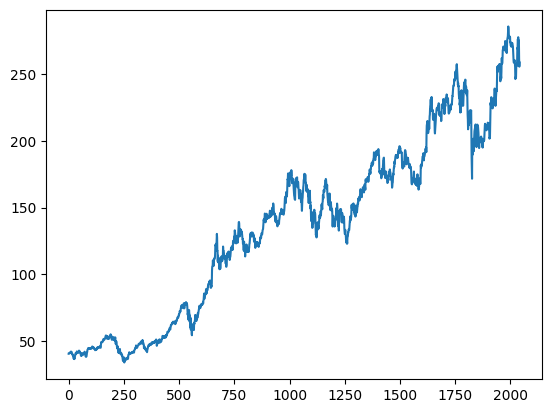

In [4]:
# Closing prices
data['Close'].plot()

Shuffling the data is not done because the aim is to predict using sequential data

In [5]:
# Looking at first 29 days to predict the 30th day
days = 29
X_close = []
y_close = []

for i in range(data.shape[0] - days):
    X_close.append(data.loc[i:(i+days-1), 'Close'])
    y_close.append([data.loc[(i+days), 'Close'].item()])

train_size = int(data.shape[0] * 0.75)

X_train = np.array(X_close[ :train_size])
y_train = np.array(y_close[ :train_size])

X_test = np.array(X_close[train_size: ])
y_test = np.array(y_close[train_size: ])

In [6]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

X_train_tensor = torch.from_numpy(X_train_scaled).type(torch.Tensor).to(device)
y_train_tensor = torch.from_numpy(y_train_scaled).type(torch.Tensor).to(device)

X_test_tensor = torch.from_numpy(X_test_scaled).type(torch.Tensor).to(device)
y_test_tensor = torch.from_numpy(y_test_scaled).type(torch.Tensor).to(device)

In [ ]:
# X data needs to be a 3D tensor: (Batch Size: How many samples?, Sequence Length: How many days are you looking back? (The "Time Steps"), Input Dim: How many features per day?)
if X_train_tensor.dim() == 2:
    print(X_train_tensor.shape)
    # unsqueeze(-1) adds a new dimension of size one at the specified position in a tensor
    X_train_tensor = X_train_tensor.unsqueeze(-1)
    print(f"Batch Size = {X_train_tensor.shape[0]}", f"Sequence Length = {X_train_tensor.shape[1]}", f"Input Dim = {X_train_tensor.shape[2]}")
else: 
    print("Correct size")

if X_test_tensor.dim() == 2:
    print(X_test_tensor.shape)
    X_test_tensor = X_test_tensor.unsqueeze(-1)
    print(f"Batch Size = {X_test_tensor.shape[0]}", f"Sequence Length = {X_test_tensor.shape[1]}", f"Input Dim = {X_test_tensor.shape[2]}")
else: 
    print("Correct size")

torch.Size([1531, 29])
Batch Size = 1531 Sequence Length = 29 Input Dim = 1
torch.Size([482, 29])
Batch Size = 482 Sequence Length = 29 Input Dim = 1


In [ ]:
class PredictionModel(nn.Module):
	def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
		super(PredictionModel, self).__init__()

		# Number of LSTM layers
		self.num_layers = num_layers	

		# Number of memory neurones per layer
		self.hidden_dim = hidden_dim

		# LSTM layer
		self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

		# Fully Connected layer
		self.fc = nn.Linear(hidden_dim, output_dim)

	# Forward pass
	def forward(self, x):
		# Blank slate initialisation
		init_hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)	# Initial short-term memory
		init_cell_state = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)	# Initial long-term memory (unique to LSTMs)

		# The LSTM takes the data batch (x) and the blank memories and cycles through the (29-day) sequence, updating its internal states at each time step
		hidden_sequences, (final_hidden_snapshot, final_cell_snapshot) = self.lstm(x, (init_hidden_state, init_cell_state))

		# Extract the final hidden state (or summary of all prior hidden states) from the very last time-step in the sequence
		final_hidden_stat = hidden_sequences[:, -1, :]

		# Condense this final hidden state with 64 hidden units into a single price prediction
		prediction = self.fc(final_hidden_stat)

		return prediction

`input_dim` : The number of features present in a single time step. In this scenario, there is only one feature per day: the closing price. 

`hidden_dim` : The number of neurons inside the LSTM cells, representing the model's *thinking space*. For example, if the `hidden_dim` is 64, the LSTM returns a *hidden state* with 64 *hidden units* representing everything it learned about the sequence (e.g., last 29 days).

`num_layers` : How many LSTMs layers stacked on top of each other. The first layer processes the input data sequence to capture basic temporal relationships (e.g., immediate price direction). Additional layers use the hidden state sequences from the previous layers as their own input, allowing the model to identify higher-level patterns (patterns of patterns) that a single layer might miss.

`output_dim` : The number of values you want the model to return. In this scenario the model is trying to predict a single feature: the closing price for the next day.

`fc` : A *fully connected* linear layer performs a weighted sum of all the insights the LSTM found, reducing the 64 abstract features from the `hidden_dim` to one prediction value. 

**Blank slate initialisation** : Since the LSTM updates memory based on the previous day, it needs a zeroed starting point for the very first point of the sequence. 

`hidden_sequences` : This contains the hidden state for every single day in the sequence (Day 1, Day 2 ... Day 29).

`(final_hidden_snapshot, final_cell_snapshot)` : These are the final snapshots of memory after the final datapoint in the sequence is finished.

In [ ]:
model = PredictionModel(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1).to(device)
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.01)

> *I'm sending you one price at a time. Use a two-layered LSTM with 64 neurons (of memory) to process the sequence. After analysing all the days, use a final layer to turn those 64 memory values into one single price prediction.*

In [ ]:
# Training
num_epochs = 200

for i in range(num_epochs):
    # Make a prediction
    y_train_pred = model(X_train_tensor)

    # Calculate loss of that prediction
    loss = criterion(y_train_pred, y_train_tensor)

    # After every 25 epochs, print the loss
    if i % 25 == 0:
        print(f"Epoch {i} | Loss : {loss.item()}")

    # Optimisation
    optimiser.zero_grad()   # Start at a gradient of zero
    loss.backward()         # Backpropagation
    optimiser.step()        # Take a step towards a more optimal direction

Epoch 0 | Loss : 0.3649423122406006
Epoch 25 | Loss : 0.00218966044485569
Epoch 50 | Loss : 0.0011935236398130655
Epoch 75 | Loss : 0.0006503500044345856
Epoch 100 | Loss : 0.0005462543340399861
Epoch 125 | Loss : 0.0004810118698514998
Epoch 150 | Loss : 0.0004470318672247231
Epoch 175 | Loss : 0.000426529033575207
